This code aims to identify the number of cells that are dead, based on uptake of PI dye in a SCR control, cells with ADAMTS19 knockdown, cells with TAX1BP1 knockdown, and cells treated with 1,6-Hexanediol.

Import Libraries

In [4]:
import czifile
import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image, display
from skimage.color import label2rgb, rgb2hsv
from skimage.filters import gaussian, sobel
from skimage.measure import label, regionprops
from skimage.morphology import binary_erosion, binary_dilation, disk, local_maxima
from scipy.ndimage import binary_fill_holes
from skimage.feature import blob_log
from skimage.color import rgb2gray
from skimage.draw import circle_perimeter
from matplotlib.colors import LogNorm
import scipy.ndimage as ndi
import pandas as pd
import os
from cellpose import models, io, plot
from skimage import morphology, io
from IPython.display import clear_output
from scipy.ndimage import zoom
import time
model = models.Cellpose(model_type='cyto')

Define Sub Function

In [5]:
target_shape = (3440, 3440)

def analyze_image(image_path, basename):
    image = czifile.imread(image_path)
    image_squeezed = np.squeeze(image)
    green_channel = image_squeezed[1,:,:]
    red_channel = image_squeezed[0,:,:]
    cell_nums = []
    cell_sizes = []
    cell_red_intensity = []
    cell_states = []
    plt.figure(figsize=(6, 6))  # Adjust figsize as needed
    plt.imshow(green_channel)
    plt.axis('off')  # Turn off axes
    # Set tight layout to minimize white space
    plt.tight_layout(pad=0)
    plt.savefig('temp_img.png')
    time.sleep(2)
    img = io.imread('temp_img.png')
    masks, flows, styles, diams = model.eval(img, diameter=None)
    labeled_image = label(masks)

    for i, region in enumerate(regionprops(labeled_image)):
        cell_size = region.area
        if region.area < 1000:
            continue
        # Create a mask for the current region and reshape it to the dimensions of the original array
        mask = labeled_image == region.label
        mask = zoom(mask, zoom=np.array(target_shape) / np.array(mask.shape), order=0)
        red_cell_mask = np.mean(red_channel[mask])
        cell_nums.append(i)
        cell_sizes.append(cell_size)
        cell_red_intensity.append(red_cell_mask)
        if red_cell_mask > 10: # Cutoff for dead or alive cell
            cell_states.append('Dead')
        else:
            cell_states.append('Alive')

    df = pd.DataFrame({
            "Filename": [basename] * len(cell_nums),
            "Cell": cell_nums,
            "Cell_Size": cell_sizes,
            "MFI_Red_Channel": cell_red_intensity,
            "Cell_State": cell_states
            })
    return df


Define Main Function

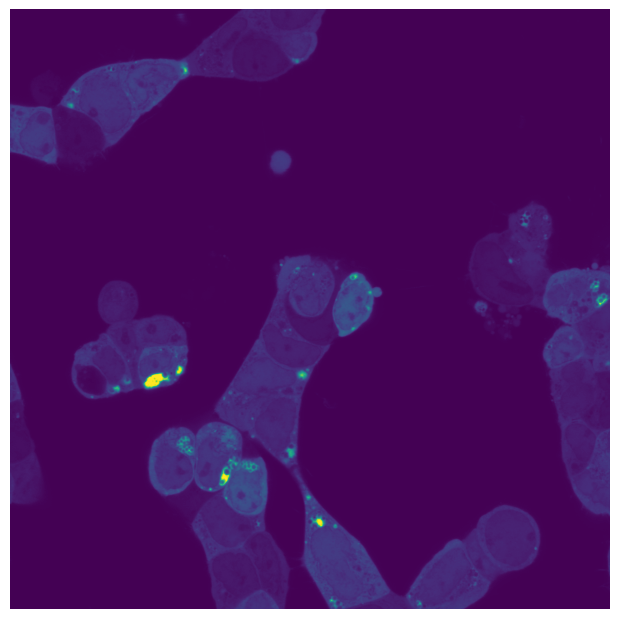

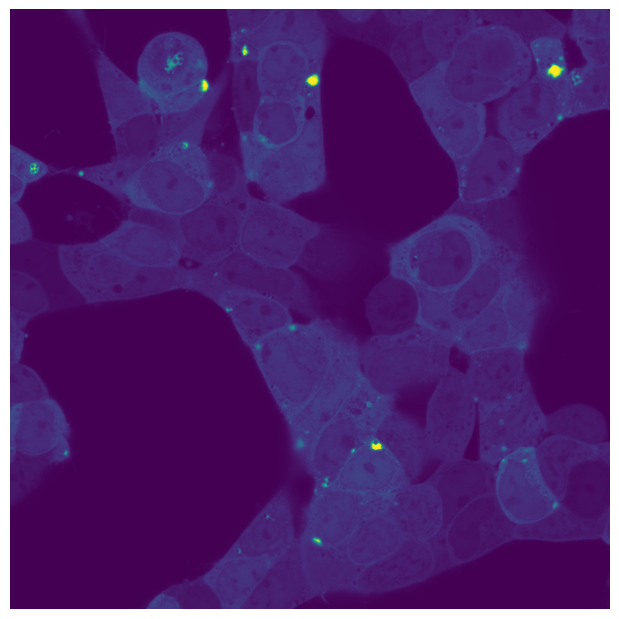

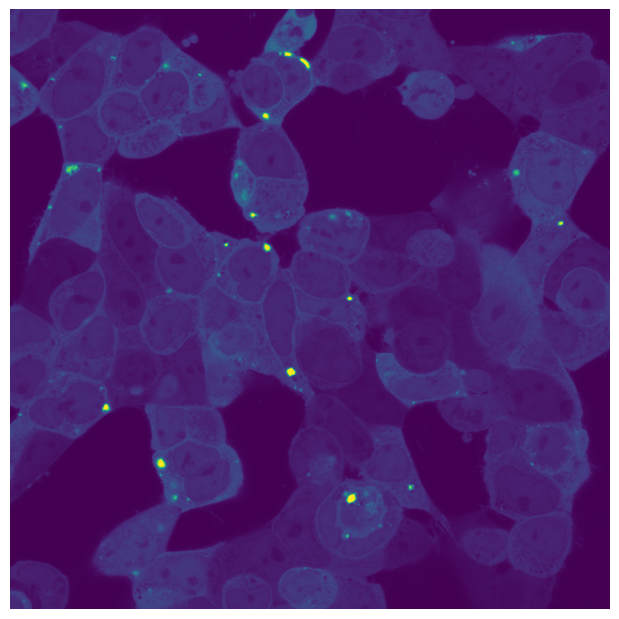

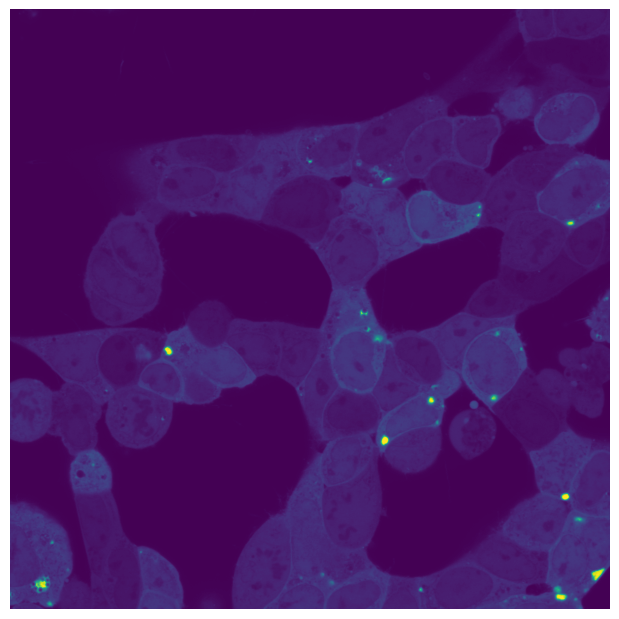

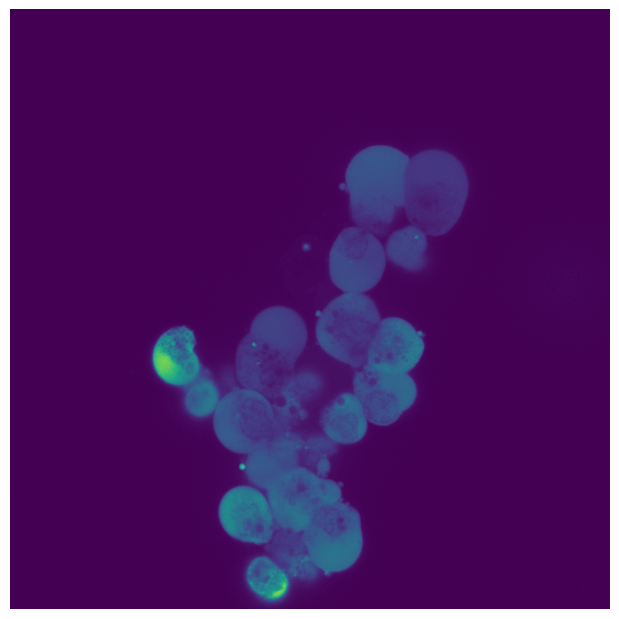

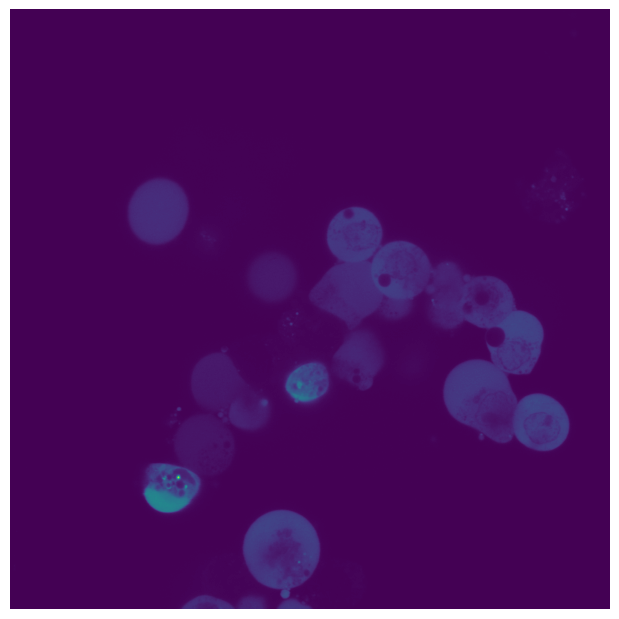

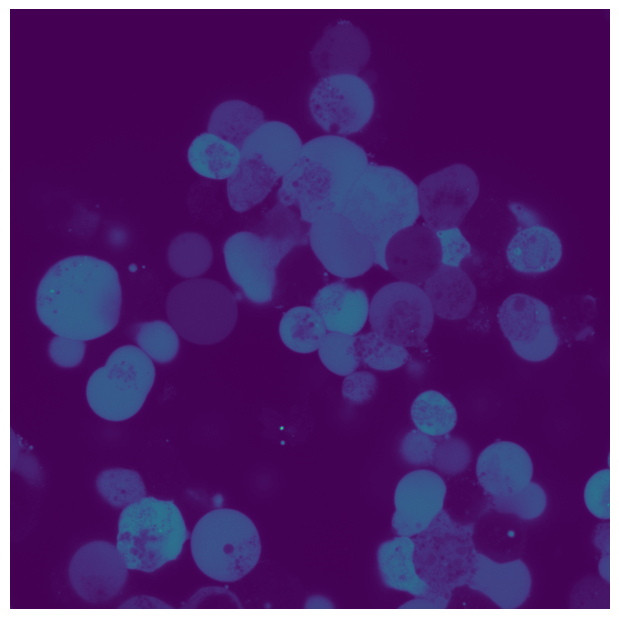

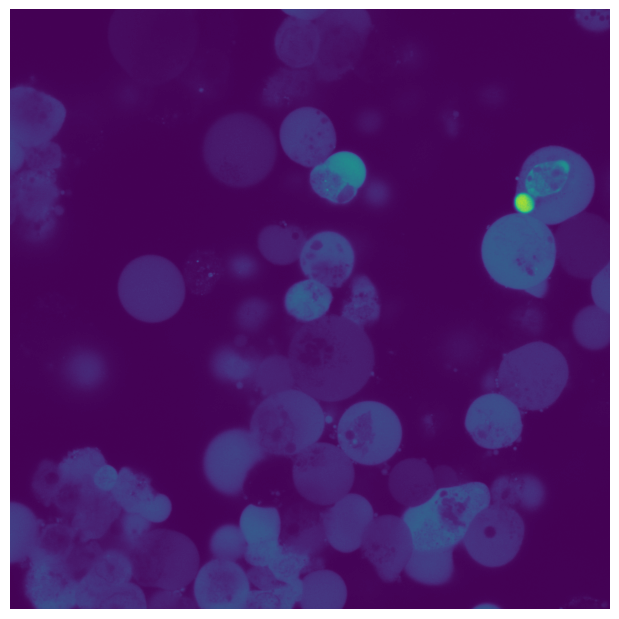

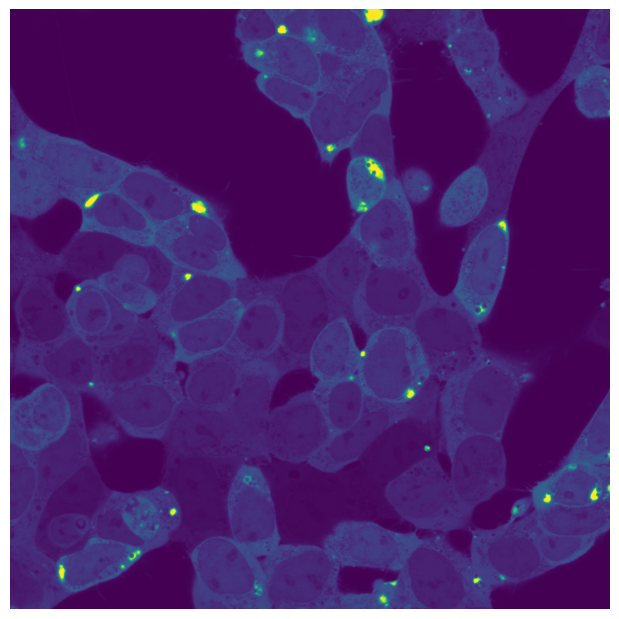

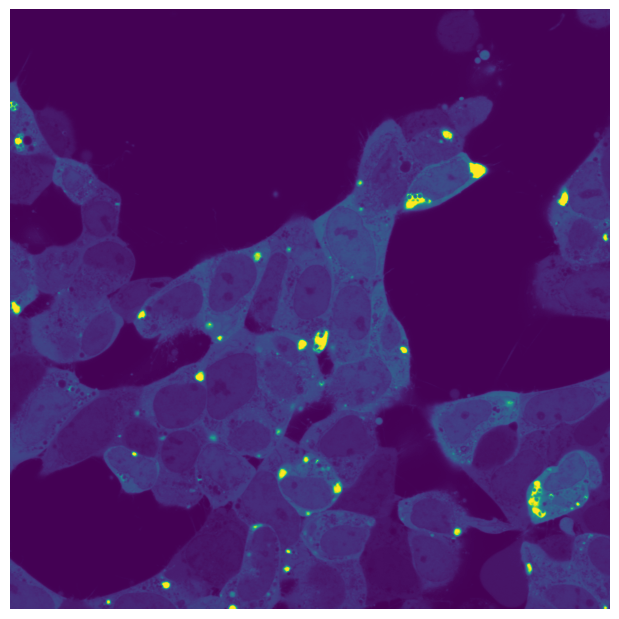

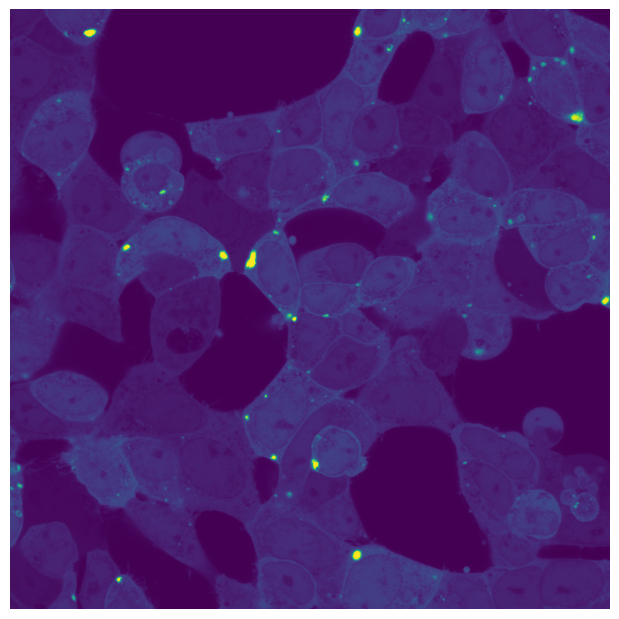

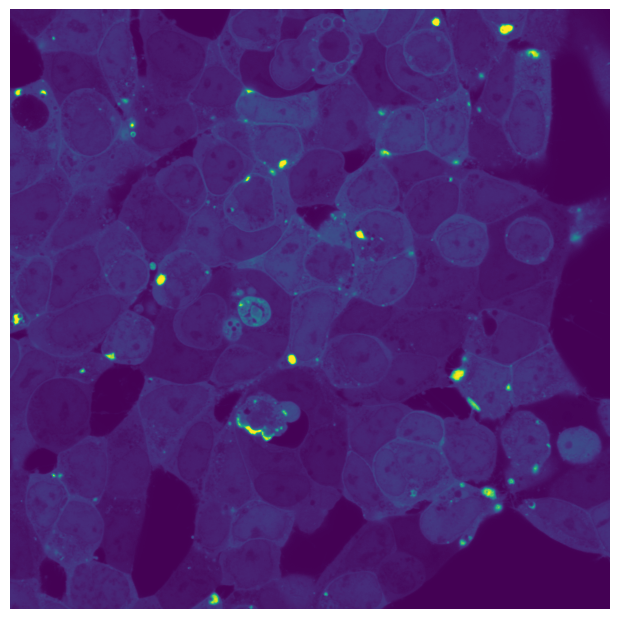

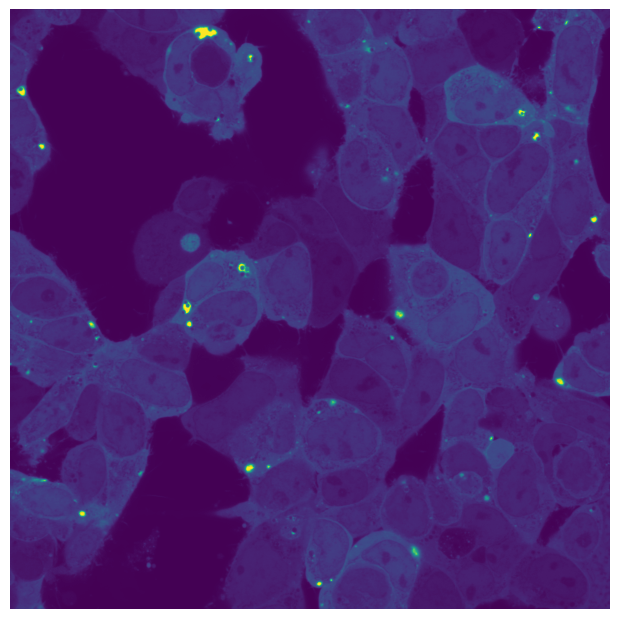

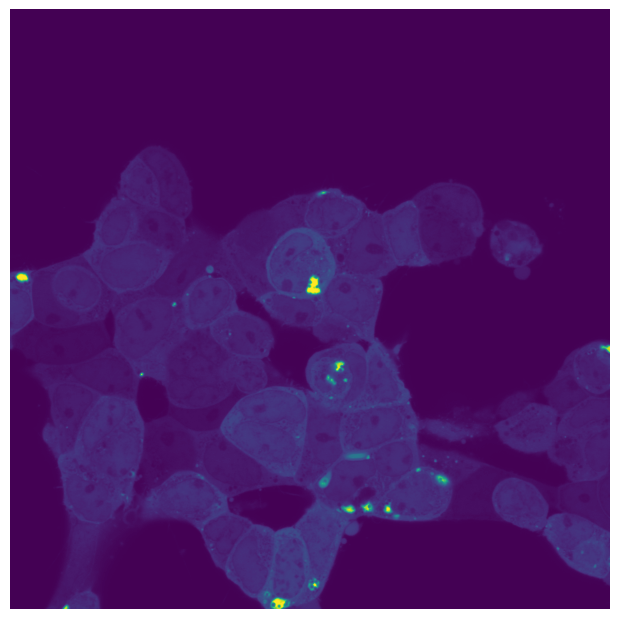

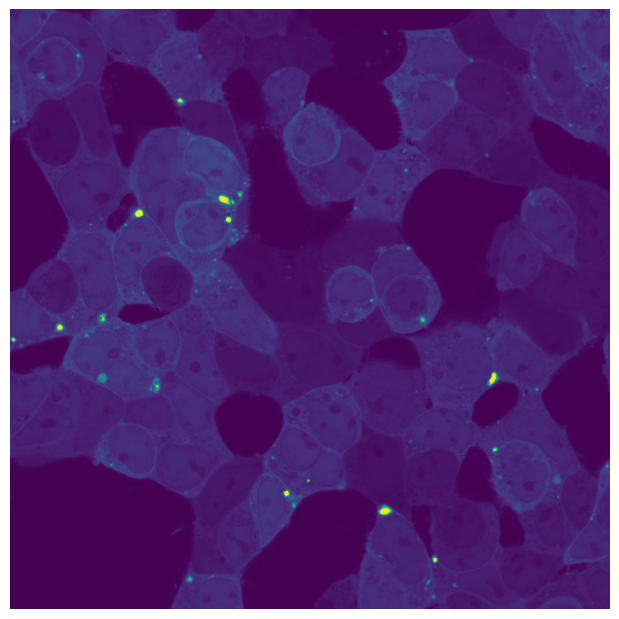

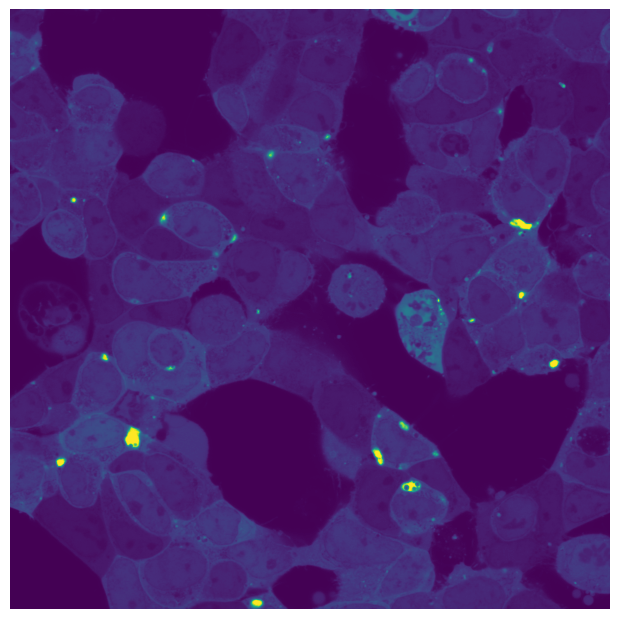

In [6]:
all_data = []
big_folder = r"test_images"

for well_image in os.listdir(big_folder):
    if well_image.lower().endswith(".czi"):  # Filter for CZI files
        well_image_path = os.path.join(big_folder, well_image)
        well_image_base_name = os.path.basename(well_image)[:-4]
        df = analyze_image(well_image_path, well_image_base_name)
        if df is not None:
            all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)

# Save the combined DataFrame to a single CSV
combined_csv_path = os.path.join(f"PI_Hoechst.xlsx")
combined_df.to_excel(combined_csv_path, index=False)